In [44]:
# ======= Step 0:  =======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# ======= Step 1:=======

data = pd.read_csv("../10_Data_Clean/final_data.csv")

data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'YEAR', 'GEO_UNIQUE_ID',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_TRACT_BURNED', 'FIRE_EXPOSED', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE',
       'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'YEAR_OF_LAST_FIRE',
       'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS',
       'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
       'MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
       'MAX_PCT_TRACT_BURNEDx_ROLLING_1yr_PRICE_CHANGE',
       'FIRE_EXPOSED_x_Median_Household_Income',
       'FIRE_EXPOSED_x_Below_Poverty_Rate', 'ROLLING_2yr

## 1. Focuse on Fire Exposure Area
Can we predict the severity of housing price declines after wildfire exposure based solely on the pre-existing economic and social characteristics of a community, thereby quantifying the role of socioeconomic vulnerability in amplifying disaster-induced housing market risks?



In [45]:
# Step 2: Filter only FIRE_EXPOSED = 1 

fire_exposed_data = data[data['FIRE_EXPOSED'] == 1].copy()


## 2. EDA

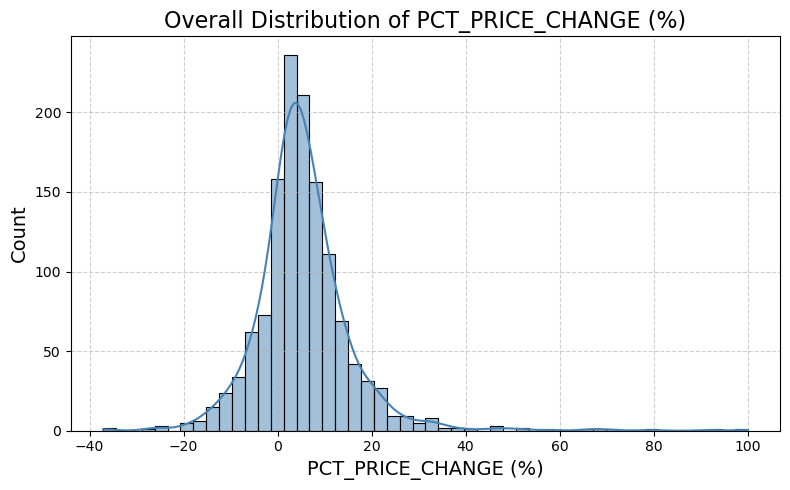

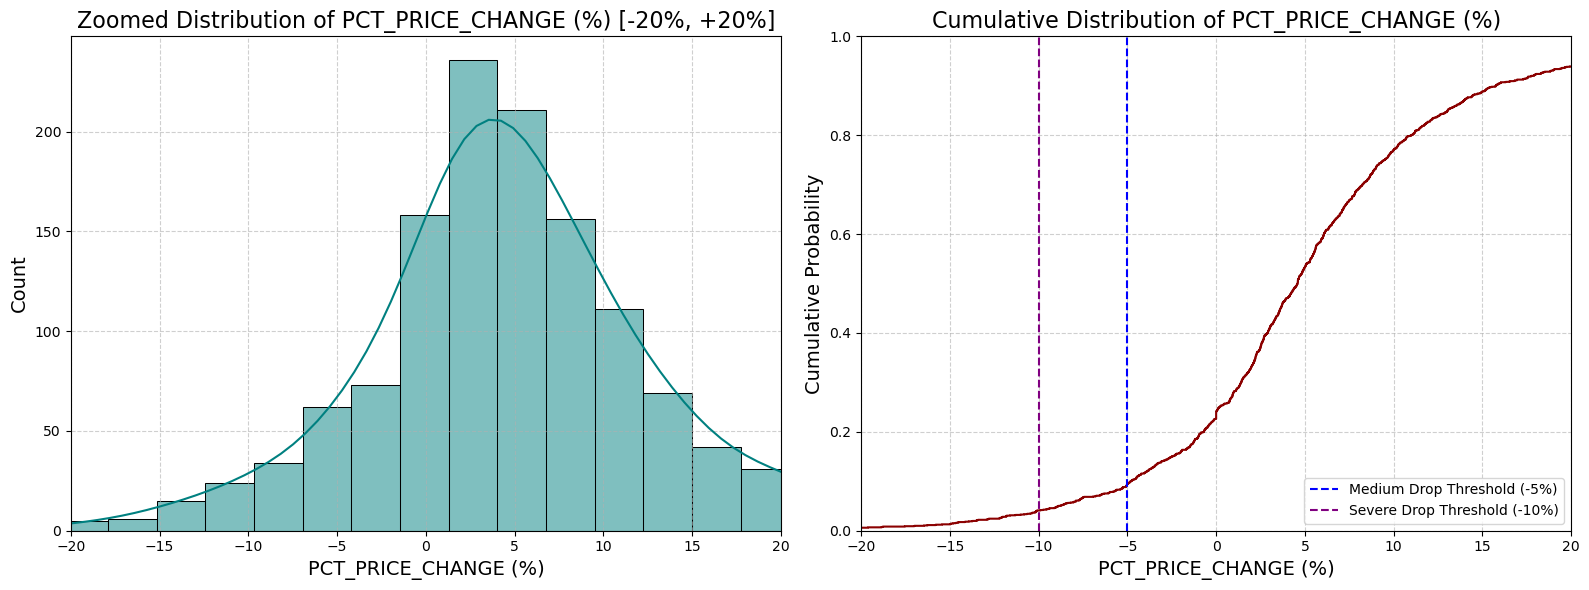

In [46]:
# Step 3: EDA - Overall Distribution
plt.figure(figsize=(8,5))
sns.histplot(fire_exposed_data['PCT_PRICE_CHANGE (%)'], bins=50, kde=True, color='steelblue')

plt.title('Overall Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
plt.xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 4: EDA - Zoomed Distribution and CDF
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Left Plot: Zoomed-in Histogram
sns.histplot(
    fire_exposed_data['PCT_PRICE_CHANGE (%)'],
    bins=50,
    kde=True,
    color='teal',
    ax=axes[0]
)
axes[0].set_xlim(-20, 20)
axes[0].set_title('Zoomed Distribution of PCT_PRICE_CHANGE (%) [-20%, +20%]', fontsize=16)
axes[0].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right Plot: Cumulative Distribution (CDF)
sns.ecdfplot(
    fire_exposed_data['PCT_PRICE_CHANGE (%)'],
    color='darkred',
    ax=axes[1]
)
axes[1].set_title('Cumulative Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
axes[1].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Mark -5% and -10% thresholds on CDF
axes[1].axvline(x=-5, color='blue', linestyle='--', label='Medium Drop Threshold (-5%)')
axes[1].axvline(x=-10, color='purple', linestyle='--', label='Severe Drop Threshold (-10%)')
axes[1].legend()

plt.tight_layout()
plt.show()

1. Zoomed-in Distribution [-20%, +20%]
The histogram of PCT_PRICE_CHANGE (%) zoomed into the [-20%, +20%] range shows:
A unimodal distribution peaking around +5%, suggesting that modest price growth was the most common outcome.
Smooth transitions between price change ranges without visible discontinuities or clustering artifacts.
Severe Drops (<-10%) are rare but evident, justifying special categorization for high-risk zones.
Medium Drops (-10% to -5%) have moderate density, providing sufficient sample size for a stable classification boundary.
The main body of data lies between -5% and +15%, supporting the economic relevance of mild market fluctuations.

**Visual inspection of the zoomed histogram supports the selection of the -5% and -10% thresholds by revealing that these cuts fall at natural points of declining frequency, ensuring that severity classes reflect meaningful differences in market dynamics.**

2. Overall Cumulative Distribution (CDF)
The cumulative distribution function (CDF) of PCT_PRICE_CHANGE (%) reveals a standard S-shaped curve, typical for unimodal, slightly skewed data:
Approximately 10% of observations experienced a price change below -10%, representing Severe Drops.
Approximately 20% of observations had price changes below -5%, encompassing both Severe and Medium Drops.
The majority of the data (over 80%) falls above -5%, indicating Small Drops or price increases.

**This validates the use of -5% and -10% thresholds for classifying risk severity, ensuring that Severe and Medium drops capture the most extreme negative outcomes without excessively fragmenting the dataset.**
**In addition, the -5% and -10% thresholds align well with natural cumulative inflection points in the data, and produce an interpretable and operationally meaningful separation of risk categories.**



In [47]:
def assign_damage_severity(pct_change):
    if pct_change >= -5:
        return 0  # Small Drop
    elif -10 <= pct_change < -5:
        return 1  # Medium Drop
    else:
        return 2  # Severe Drop


# Apply function
fire_exposed_data['DAMAGE_SEVERITY_CLASS'] = fire_exposed_data['PCT_PRICE_CHANGE (%)'].apply(assign_damage_severity)


The DAMAGE_SEVERITY_CLASS variable was constructed based on thresholds identified through distributional analysis of PCT_PRICE_CHANGE (%). Observations with declines less than -10% were classified as Severe Drops (2), those between -5% and -10% as Medium Drops (1), and all others as Small Drops (0), ensuring a data-driven and economically interpretable stratification of post-wildfire housing risks.

/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_20802/1478081649.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=fire_exposed_data, palette='Set2')


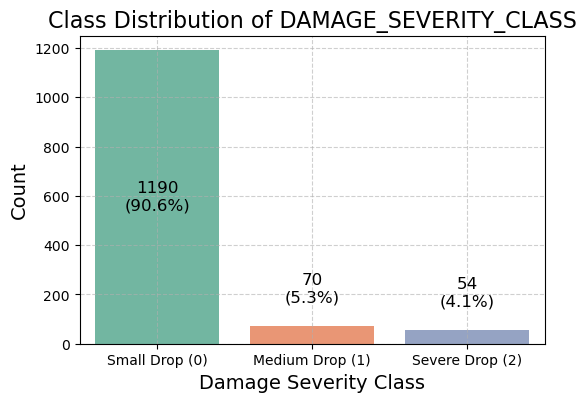

In [48]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=fire_exposed_data, palette='Set2')

plt.title('Class Distribution of DAMAGE_SEVERITY_CLASS', fontsize=16)
plt.xlabel('Damage Severity Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([0,1,2], ['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)'])

counts = fire_exposed_data['DAMAGE_SEVERITY_CLASS'].value_counts().sort_index()
percentages = fire_exposed_data['DAMAGE_SEVERITY_CLASS'].value_counts(normalize=True).sort_index()

for i, (count, pct) in enumerate(zip(counts, percentages)):
    if i == 0:
        ax.text(i, count/2, f'{count}\n({pct:.1%})', ha='center', va='center', fontsize=12, color='black')
    else:
        ax.text(i, count + 100, f'{count}\n({pct:.1%})', ha='center', fontsize=12, color='black')

plt.show()


**Class Balance Analysis**   
The distribution of the DAMAGE_SEVERITY_CLASS variable reveals substantial class imbalance (Figure X). Specifically, 90.5% of observations correspond to Small Drops (0), 5.4% to Medium Drops (1), and 4.1% to Severe Drops (2). Although this imbalance reflects the natural rarity of significant market downturns following wildfire exposure, it poses challenges for classification model performance, particularly in accurately identifying minority classes.  
To mitigate this, we plan to adopt evaluation metrics such as the Macro F1 Score, which equally weights performance across all classes, and explore techniques such as class weighting or sampling strategies to improve model sensitivity to less frequent but critical outcomes.  
Correctly identifying the most severe housing market disruptions is crucial for informing investment, insurance, and policy decisions in fire-prone regions.

## 3. Model Preparation

In [49]:
baseline_feature_cols = [
    'Median_Household_Income',
    'Total_Population',
    'Avg_Household_Size',
    'Gini_Index',
    'Employment_Rate',
    'Below_Poverty_Rate',
    'Rate_College_or_Higher',
    'Black_Portion',
    'White_Portion',
    'American_Indian_and_Alaska_Native_Portion',
    'Asian_Portion',
    'YEARS_SINCE_LAST_FIRE',
    'CUMULATIVE_AREA_BURNED_LAST_2YRS',
    'PREV_MAX_PCT_TRACT_BURNED',        
    'ROLLING_2yr_PRICE_CHANGE_STD' 
]



TRAIN_YEAR_CUTOFF = 2017

train_df = fire_exposed_data[fire_exposed_data['YEAR'] <= TRAIN_YEAR_CUTOFF]
test_df = fire_exposed_data[fire_exposed_data['YEAR'] > TRAIN_YEAR_CUTOFF]

X_train = train_df[baseline_feature_cols]
y_train = train_df['DAMAGE_SEVERITY_CLASS']

X_test = test_df[baseline_feature_cols]
y_test = test_df['DAMAGE_SEVERITY_CLASS']



### test class balance to update train year cutoff

/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_20802/1102560855.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, palette='Set2', ax=axes[0])
/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_20802/1102560855.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)'])
/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_20802/1102560855.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, palette='Set2', ax=axes[1])
/

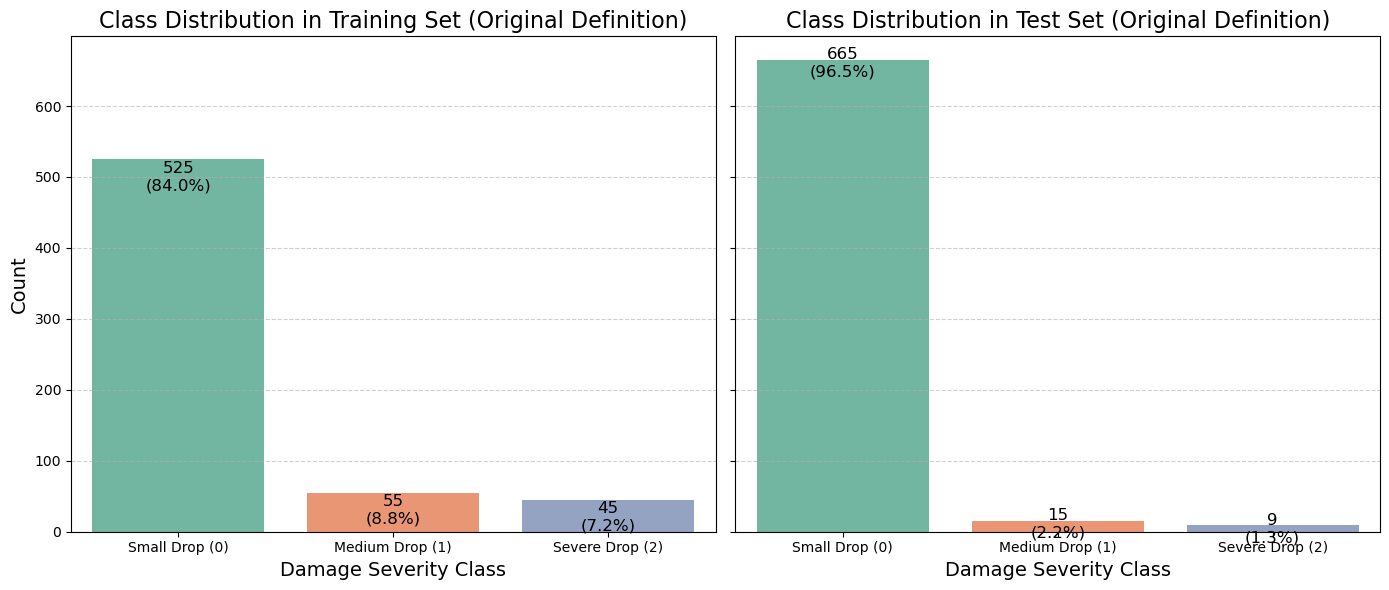

In [50]:
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

train_percentages = y_train.value_counts(normalize=True).sort_index()
test_percentages = y_test.value_counts(normalize=True).sort_index()

# Create a 1-row 2-column plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left: Training Set ---
sns.barplot(x=train_counts.index, y=train_counts.values, palette='Set2', ax=axes[0])
axes[0].set_title('Class Distribution in Training Set (Original Definition)', fontsize=16)
axes[0].set_xlabel('Damage Severity Class', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].set_xticklabels(['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)'])
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

for i, (count, pct) in enumerate(zip(train_counts, train_percentages)):
    axes[0].text(i, count-25, f'{count}\n({pct:.1%})', ha='center', va='center', fontsize=12, color='black')

# --- Right: Testing Set ---
sns.barplot(x=test_counts.index, y=test_counts.values, palette='Set2', ax=axes[1])
axes[1].set_title('Class Distribution in Test Set (Original Definition)', fontsize=16)
axes[1].set_xlabel('Damage Severity Class', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)'])
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

for i, (count, pct) in enumerate(zip(test_counts, test_percentages)):
    axes[1].text(i, count-5, f'{count}\n({pct:.1%})', ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


## 5. Baseline Majority Classifier

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# === Step 1: Baseline Naive Majority Classifier ===
majority_clf = DummyClassifier(strategy='most_frequent') 
majority_clf.fit(X_train, y_train)

# === Step 2: Predict on Test Set ===
y_pred_baseline = majority_clf.predict(X_test)

# === Step 3: Evaluate ===
print("=== Baseline Majority Classifier Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_baseline, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))


=== Baseline Majority Classifier Performance ===
Accuracy: 0.9652
Macro F1 Score: 0.3274

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.97      1.00      0.98       665
Medium Drop (1)       0.00      0.00      0.00        15
Severe Drop (2)       0.00      0.00      0.00         9

       accuracy                           0.97       689
      macro avg       0.32      0.33      0.33       689
   weighted avg       0.93      0.97      0.95       689


Confusion Matrix:
[[665   0   0]
 [ 15   0   0]
 [  9   0   0]]


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

**Baseline Model Analysis**  
The naive majority class classifier, which always predicts the Small Drop (0) category, achieved a high overall accuracy of 97.57% due to the dominant class imbalance. However, this high accuracy is misleading, as the Macro F1 Score was only 0.3292, indicating poor performance on the minority classes (Medium and Severe Drops). The confusion matrix confirms that no Medium or Severe Drops were correctly identified.
This baseline establishes a minimal benchmark that subsequent XGBoost models must surpass, particularly by improving recall and F1 scores for the critical minority categories.





## 6. XGBoost Majority Classifier (original)

In [52]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.3968253968253968, 1: 3.787878787878788, 2: 4.62962962962963}


In [54]:
# No need to scale
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

sample_weights = y_train.map(class_weight_dict)

xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [55]:
# Test Set prediction
y_pred_xgb = xgb_clf.predict(X_test)

print("=== XGBoost Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


=== XGBoost Model Performance ===
Accuracy: 0.9637
Macro F1 Score: 0.3642

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.97      1.00      0.98       665
Medium Drop (1)       0.33      0.07      0.11        15
Severe Drop (2)       0.00      0.00      0.00         9

       accuracy                           0.96       689
      macro avg       0.43      0.35      0.36       689
   weighted avg       0.94      0.96      0.95       689


Confusion Matrix:
[[663   2   0]
 [ 14   1   0]
 [  9   0   0]]


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## 7. XGBoost Majority Classifier (SMOTE)

In [56]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Step 1: SMOTE 
smote = SMOTE(sampling_strategy={1: 300, 2: 300}, random_state=42) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))


Before SMOTE: [525  55  45]
After SMOTE: [525 300 300]


In [57]:
# Step 2: Train XGBoost on Resampled Data (no need for sample_weight anymore)
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [58]:
# Step 3: Test Set prediction
y_pred_xgb = xgb_clf.predict(X_test)

print("=== XGBoost Model Performance (After SMOTE) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Small Drop (0)', 'Medium Drop (1)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


=== XGBoost Model Performance (After SMOTE) ===
Accuracy: 0.9623
Macro F1 Score: 0.4178

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.97      0.99      0.98       665
Medium Drop (1)       0.25      0.07      0.11        15
Severe Drop (2)       0.33      0.11      0.17         9

       accuracy                           0.96       689
      macro avg       0.52      0.39      0.42       689
   weighted avg       0.95      0.96      0.95       689


Confusion Matrix:
[[661   3   1]
 [ 13   1   1]
 [  8   0   1]]


## 8. XGBoost Majority Classifier (Hyperparameter Tunning)